## 7.4 Networks with Parallel Concatenations(GoogLeNet)
### 7.4.1 Inception Blocks

In [3]:
from d2l import mxnet as d2l
from mxnet import np,npx
from mxnet.gluon import nn
from tools import net_details
npx.set_np()

In [2]:
class Inception(nn.Block):
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2D(c1, kernel_size=1, activation='relu')
        self.p2_1 = nn.Conv2D(c2[0], kernel_size=1, activation='relu')
        self.p2_2 = nn.Conv2D(c2[1], kernel_size=3, padding=1, activation='relu')
        self.p3_1 = nn.Conv2D(c3[0], kernel_size=1, activation='relu')
        self.p3_2 = nn.Conv2D(c3[1], kernel_size=5, padding=2, activation='relu')
        self.p4_1 = nn.MaxPool2D(pool_size=3, strides=1, padding=1)
        self.p4_2 = nn.Conv2D(c4, kernel_size=1, activation='relu')

    def forward(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        return np.concatenate((p1, p2, p3, p4), axis=1)

In [5]:
b1 = nn.Sequential()
b1.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3, activation='relu'),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))
b2 = nn.Sequential()
b2.add(nn.Conv2D(64, kernel_size=1, activation='relu'),
        nn.Conv2D(192, kernel_size=3, padding=1, activation='relu'),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))
b3 = nn.Sequential()
b3.add(Inception(64, (96, 128), (16, 32), 32),
        Inception(128, (128, 192), (32, 96), 64),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))
b4 = nn.Sequential()
b4.add(Inception(192, (96, 208), (16, 48), 64),
        Inception(160, (112, 224), (24, 64), 64),
        Inception(128, (128, 256), (24, 64), 64),
        Inception(256, (160, 320), (32, 128), 128),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))
b5 = nn.Sequential()
b5.add(Inception(256, (160, 320), (32, 128), 128),
        Inception(384, (192, 384), (48, 128), 128),
        nn.GlobalMaxPool2D())
net = nn.Sequential()
net.add(b1, b2, b3, b4, b5, nn.Dense(10))

In [6]:
X = np.random.uniform(size=(1, 1, 96, 96))
net.initialize()
net_details(X, net)

sequential6 output shape:	 (1, 64, 24, 24)
sequential7 output shape:	 (1, 192, 12, 12)
sequential8 output shape:	 (1, 480, 6, 6)
sequential9 output shape:	 (1, 832, 3, 3)
sequential10 output shape:	 (1, 1024, 1, 1)
dense1 output shape:	 (1, 10)


loss 0.077, train acc 0.972, test acc 0.936
1429.2 examples/sec on gpu(0)


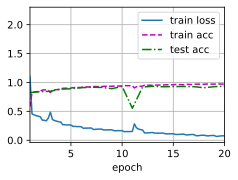

In [13]:
lr, num_epochs, batch_size = 0.1, 20, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

In [8]:
class BN_Inception(nn.Block):
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(BN_Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2D(c1, kernel_size=1)
        self.p1_11 = nn.BatchNorm()
        self.p1_12 = nn.Activation('relu')

        self.p2_1 = nn.Conv2D(c2[0], kernel_size=1)
        self.p2_11 = nn.BatchNorm()
        self.p2_12 = nn.Activation('relu')
        self.p2_2 = nn.Conv2D(c2[1], kernel_size=3, padding=1)
        self.p2_21 = nn.BatchNorm()
        self.p2_22 = nn.Activation('relu')

        self.p3_1 = nn.Conv2D(c3[0], kernel_size=1)
        self.p3_11 = nn.BatchNorm()
        self.p3_12 = nn.Activation('relu')
        self.p3_2 = nn.Conv2D(c3[1], kernel_size=5, padding=2)
        self.p3_21 = nn.BatchNorm()
        self.p3_22 = nn.Activation('relu')

        self.p4_1 = nn.MaxPool2D(pool_size=3, strides=1, padding=1)
        self.p4_2 = nn.Conv2D(c4, kernel_size=1)
        self.p4_21 = nn.BatchNorm()
        self.p4_22 = nn.Activation('relu')

    def forward(self, x):
        p1 = self.p1_12(self.p1_11(self.p1_1(x)))
        p2 = self.p2_12(self.p2_11(self.p2_1(x)))
        p2 = self.p2_22(self.p2_21(self.p2_2(p2)))
        p3 = self.p3_12(self.p3_11(self.p3_1(x)))
        p3 = self.p3_22(self.p3_21(self.p3_2(p2)))
        p4 = self.p4_1(x)
        p4 = self.p4_22(self.p4_21(self.p4_2(p2)))
        return np.concatenate((p1, p2, p3, p4), axis=1)

In [9]:
b1 = nn.Sequential()
b1.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3),
        nn.BatchNorm(),
        nn.Activation('relu'),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))
b2 = nn.Sequential()
b2.add(nn.Conv2D(64, kernel_size=1),
        nn.BatchNorm(),
        nn.Activation('relu'),
        nn.Conv2D(192, kernel_size=3, padding=1),
        nn.BatchNorm(),
        nn.Activation('relu'),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))
b3 = nn.Sequential()
b3.add(Inception(64, (96, 128), (16, 32), 32),
        Inception(128, (128, 192), (32, 96), 64),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))
b4 = nn.Sequential()
b4.add(Inception(192, (96, 208), (16, 48), 64),
        Inception(160, (112, 224), (24, 64), 64),
        Inception(128, (128, 256), (24, 64), 64),
        Inception(256, (160, 320), (32, 128), 128),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))
b5 = nn.Sequential()
b5.add(Inception(256, (160, 320), (32, 128), 128),
        Inception(384, (192, 384), (48, 128), 128),
        nn.GlobalMaxPool2D())
net = nn.Sequential()
net.add(b1, b2, b3, b4, b5, nn.Dense(10))

In [10]:
X = np.random.uniform(size=(1, 1, 96, 96))
net.initialize()
net_details(X, net)

sequential12 output shape:	 (1, 64, 24, 24)
sequential13 output shape:	 (1, 192, 12, 12)
sequential14 output shape:	 (1, 480, 6, 6)
sequential15 output shape:	 (1, 832, 3, 3)
sequential16 output shape:	 (1, 1024, 1, 1)
dense2 output shape:	 (1, 10)


loss 0.075, train acc 0.972, test acc 0.923
1362.6 examples/sec on gpu(0)


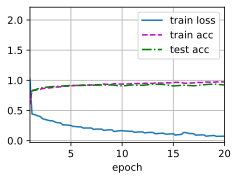

In [12]:
lr, num_epochs, batch_size = 0.1, 20, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

ToDo：为什么归一化 Inception 的效果没有原始的好呢？